# Simple 2D Sparse GP
We will test to ensure that our sparse GP implementation works correctly in this notebook.

## Generate Syntethic Data
We generate a simple dataset for testing with inputs in the range [0, 200]. We'll use a sinusoidal function with some noise added.

In [1]:
import jax
import jax.numpy as np
from jax import random
from jax.scipy.linalg import cho_factor, cho_solve

import numpy as onp
import matplotlib.pyplot as plt

from sparse_gp import *

prng_key = random.key(0)

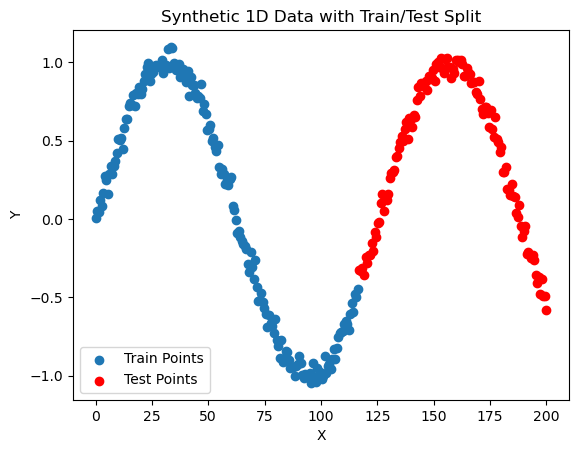

In [2]:
# Inputs
X = onp.linspace(0, 200, 300).reshape(-1, 1)

# Outputs: Sine function with noise
Y = onp.sin(X * 0.05) + 0.05 * onp.random.normal(size=X.shape)

# Training and testing split
X_train, Y_train = X[:175], Y[:175]
X_test, Y_test = X[175:], Y[175:]

# Plot data
plt.scatter(X_train, Y_train, label="Train Points")
plt.scatter(X_test, Y_test, label="Test Points", color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Synthetic 1D Data with Train/Test Split")
plt.show()

## Plotting Code
### Predictive Mean and Uncertainty Plot

In [3]:
def plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, model_fn, show_inducing=True):
    """
    Plots the sparse Gaussian Process predictions with uncertainty.
    Includes the option to show inducing points with their respective pseudo-observations.
    
    Parameters:
        X_train (array): Training input points.
        Y_train (array): Training output points.
        X_test (array): Test input points.
        Y_test (array): Test output points.
        Z (array): Inducing points (input locations).
        optimized_hyperparams: Optimized hyperparameters for the model.
        model_fn (function): Function that makes predictions.
        show_inducing (bool): Whether to plot the inducing points with their pseudo-observations.
    """
    # Ensure input arrays are two-dimensional
    X_test = X_test.reshape(-1, 1)
    X_train = X_train.reshape(-1, 1)
    Z = Z.reshape(-1, 1)

    # Make predictions on the test set
    posterior_mean, posterior_var = model_fn(X_test, X_train, Y_train, Z, optimized_hyperparams)

    # Compute pseudo-observations at inducing points
    inducing_mean, _ = model_fn(Z, X_train, Y_train, Z, optimized_hyperparams)

    # Convert JAX arrays to NumPy arrays
    posterior_mean = onp.array(posterior_mean).flatten()
    posterior_var = onp.array(posterior_var).flatten()
    X_test = onp.array(X_test).flatten()
    Z = onp.array(Z).flatten()
    inducing_mean = onp.array(inducing_mean).flatten()

    # Ensure variances are positive
    posterior_var = onp.maximum(posterior_var, 1e-10)

    # Plot data and predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, Y_train, color='blue', alpha=0.7, label="Training Points")
    plt.scatter(X_test, Y_test, color='red', alpha=0.7, label="Test Points")
    plt.plot(X_test, posterior_mean, 'green', label="Predicted Mean")
    plt.fill_between(X_test,
                     posterior_mean - 1.96 * onp.sqrt(posterior_var),
                     posterior_mean + 1.96 * onp.sqrt(posterior_var),
                     color='green', alpha=0.2, label="95% Confidence Interval")

    # Plot inducing points if show_inducing is True
    if show_inducing:
        plt.scatter(Z, inducing_mean, color='orange', s=100, label="Inducing Points", marker='x', zorder=5)

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
    plt.title(f"Sparse GP Prediction with Uncertainty (Inducing Points: {len(Z)})")
    plt.show()
#

### Negative Log Predictive Density Plot

In [4]:
def calculate_nlpd(X, Y, Z, hyperparams, model_fn):
    noise_variance = np.sum(np.array([optimized_hyperparams[i] for i in [3, 6, 8, 11, 15]]))
    posterior_mean, posterior_var = model_fn(X, X_train, Y_train, Z, hyperparams)
    nlpd = neg_log_predictive_density(Y, posterior_mean, posterior_var, noise_variance)
    return nlpd
#

### ELBO Plot

In [5]:
def plot_elbo(history):
    # Extract ELBO values and steps from history
    elbo_values = [entry["elbo"] for entry in history]
    steps = [entry["step"] for entry in history]
    
    # Plot the ELBO values over steps
    plt.figure(figsize=(10, 5))
    plt.plot(steps, elbo_values, label="ELBO", color='blue')
    plt.xlabel("Step")
    plt.ylabel("ELBO")
    plt.title("ELBO Over Training Steps")
    plt.legend()
    plt.show()
#

### Kernel Hyperparameter Plot

In [6]:
def plot_kernel_hyperparameters(history, num_spectral_mixtures=10, dims=1):
    """
    Plot kernel hyperparameters over training steps, including individual mixtures for the spectral mixture kernel.
    
    Arguments:
    - history: List of dictionaries containing step and hyperparameters.
    - num_spectral_mixtures: Number of mixtures in the spectral mixture kernel.
    - dims: Number of dimensions for the spectral mixture kernel.
    """
    # Extract training steps
    steps = [entry["step"] for entry in history]
    
    # Function to normalize values between 0 and 1
    def normalize(values):
        min_val, max_val = min(values), max(values)
        return [(v - min_val) / (max_val - min_val) for v in values] if max_val > min_val else values
    #

    # Extract and normalize raw hyperparameters
    weights_1 = normalize([entry["hyperparams"][0] for entry in history])
    weights_2 = normalize([entry["hyperparams"][1] for entry in history])
    weights_3 = normalize([entry["hyperparams"][2] for entry in history])
    
    signal_variance_sqexp = normalize([entry["hyperparams"][4] for entry in history])
    length_scale_sqexp = normalize([entry["hyperparams"][5] for entry in history])
    signal_variance_linear = normalize([entry["hyperparams"][7] for entry in history])
    signal_variance_matern = normalize([entry["hyperparams"][9] for entry in history])
    length_scale_matern = normalize([entry["hyperparams"][10] for entry in history])
    
    signal_variance_sinusoidal = normalize([entry["hyperparams"][13] for entry in history])
    period_sinusoidal = normalize([entry["hyperparams"][14] for entry in history])
    length_scale_sinusoidal = normalize([entry["hyperparams"][15] for entry in history])

    # Spectral mixture kernel hyperparameters
    sm_offset = 16  # Offset for the spectral mixture kernel parameters
    spectral_mixture_weights = [
        normalize([entry["hyperparams"][sm_offset + i * (1 + 2 * dims)] for entry in history])
        for i in range(num_spectral_mixtures)
    ]
    spectral_mixture_means = [
        [
            normalize([entry["hyperparams"][sm_offset + 1 + i * (1 + 2 * dims) + j] for entry in history])
            for j in range(dims)
        ]
        for i in range(num_spectral_mixtures)
    ]
    spectral_mixture_variances = [
        [
            normalize([entry["hyperparams"][sm_offset + 1 + dims + i * (1 + 2 * dims) + j] for entry in history])
            for j in range(dims)
        ]
        for i in range(num_spectral_mixtures)
    ]

    # Plot normalized kernel hyperparameters
    plt.figure(figsize=(12, 8))

    # Plot for Squared-Exponential Kernel
    plt.plot(steps, weights_1, label="Weight (Squared-Exponential)", color='blue', linestyle='--')
    plt.plot(steps, signal_variance_sqexp, label="Signal Variance (Sq-Exp)", color='blue', linestyle='-')
    plt.plot(steps, length_scale_sqexp, label="Length Scale (Sq-Exp)", color='blue', linestyle=':')

    # Plot for Linear Kernel
    plt.plot(steps, weights_2, label="Weight (Linear)", color='red', linestyle='--')
    plt.plot(steps, signal_variance_linear, label="Signal Variance (Linear)", color='red', linestyle='-')

    # Plot for Matern Kernel
    plt.plot(steps, weights_3, label="Weight (Matern)", color='green', linestyle='--')
    plt.plot(steps, signal_variance_matern, label="Signal Variance (Matern)", color='green', linestyle='-')
    plt.plot(steps, length_scale_matern, label="Length Scale (Matern)", color='green', linestyle=':')

    # Plot for Sinusoidal Kernel
    plt.plot(steps, signal_variance_sinusoidal, label="Signal Variance (Sinusoidal)", color='purple', linestyle='-')
    plt.plot(steps, period_sinusoidal, label="Period (Sinusoidal)", color='purple', linestyle='--')
    plt.plot(steps, length_scale_sinusoidal, label="Length Scale (Sinusoidal)", color='purple', linestyle=':')

    # Plot for Spectral Mixture Kernel (Each mixture in a different color)
    colors = plt.cm.viridis(np.linspace(0, 1, num_spectral_mixtures))  # Generate unique colors for mixtures
    for i in range(num_spectral_mixtures):
        plt.plot(steps, spectral_mixture_weights[i], label=f"SM Weight {i + 1}", color=colors[i], linestyle='-')
        for j in range(dims):
            plt.plot(steps, spectral_mixture_means[i][j], label=f"SM Mean {i + 1}, Dim {j + 1}", color=colors[i], linestyle='--')
            plt.plot(steps, spectral_mixture_variances[i][j], label=f"SM Variance {i + 1}, Dim {j + 1}", color=colors[i], linestyle=':')

    # Plot configuration
    plt.xlabel("Step")
    plt.ylabel("Normalized Parameter Value (0 to 1)")
    plt.title("Normalized Kernel Hyperparameter Values Over Training Steps")
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()
#

# Test Experiment 1
Test on 20 inducing points.

## Parameter Initialization

In [7]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train, num_inducing=20)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams(X_train):
    # Determine the number of input dimensions from X_train
    dims = X_train.shape[1]
    
    # Three initial weights in log space for unconstrained optimization (converted to float)
    initial_weights = [float(np.log(0.33)), float(np.log(0.33)), float(np.log(0.33))]
    
    # Initial hyperparameters for each kernel
    hyperparams_sqexp = [0.1, 1.0, 10.0]        # [noise_variance, signal_variance, length_scale]
    hyperparams_linear = [0.1, 1.0]             # [noise_variance, signal_variance]
    hyperparams_matern = [0.1, 1.0, 10.0]       # [noise_variance, signal_variance, length_scale]
    hyperparams_sinusoidal = [0.1, 1.0, 10.0, 1.0]  # [noise_variance, signal_variance, period, length_scale]

    # Initialize spectral mixture hyperparameters
    num_mixtures = 2
    hyperparams_spectralmixture = [0.1]  # Start with noise_variance and number of mixtures

    for _ in range(num_mixtures):
        weight = 1 / num_mixtures  # Equal weight for each mixture initially
        mean = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        variance = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        hyperparams_spectralmixture.append(weight)  # Add weight
        hyperparams_spectralmixture.extend(mean)  # Add flattened mean
        hyperparams_spectralmixture.extend(variance)  # Add flattened variance
    #

    # Concatenate all hyperparameters
    initial_params = (
        initial_weights +
        hyperparams_sqexp +
        hyperparams_linear +
        hyperparams_matern +
        hyperparams_sinusoidal +
        hyperparams_spectralmixture
    )
    
    return np.array(initial_params, dtype=np.float32)
#


# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train)

## Define the Optimization Loop for ELBO

In [8]:
# Set the gradient ascent step size and number of steps
step_size = 5e-3
num_steps = 500

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train, Y_train, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -247.18620932227907
Step 10, ELBO: -231.88765287865843
Step 20, ELBO: -217.66292717651254
Step 30, ELBO: -204.28545005911724
Step 40, ELBO: -192.26179711878555
Step 50, ELBO: -181.74925272519505
Step 60, ELBO: -172.81400395889602
Step 70, ELBO: -165.2730968879359
Step 80, ELBO: -158.60244803769265
Step 90, ELBO: -164.99666146593842
Step 100, ELBO: -167.37667602978757
Step 110, ELBO: -166.53253566397197
Step 120, ELBO: -161.86050417531146
Step 130, ELBO: -164.57302130983675
Step 140, ELBO: -156.1191851995904
Step 150, ELBO: -157.7314354503305
Step 160, ELBO: -132.66378129205228
Step 170, ELBO: -107.12725655669234
Step 180, ELBO: -91.88665477080714
Step 190, ELBO: -77.70867586617325
Step 200, ELBO: -64.21444539049419
Step 210, ELBO: -51.307250423793974
Step 220, ELBO: -38.763530481048846
Step 230, ELBO: -27.251115342098927
Step 240, ELBO: -17.463031976598955
Step 250, ELBO: -9.196512516305887
Step 260, ELBO: -2.452991737971729
Step 270, ELBO: 2.8276746519073868
Step 280, EL

In [9]:
print("Optimized Hyperparameters:", optimized_hyperparams)

total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [3, 6, 8, 11, 15]]))
print("\nTotal noise:", total_noise)

# percentage of change in each hyperparameter
print("\nPercentage of change in each hyperparameter:")
for i in range(1, len(optimized_hyperparams)):
    print(f"Hyperparameter {i}: {100 * (optimized_hyperparams[i] - unconstrained_hyperparams_init[i]) / unconstrained_hyperparams_init[i]:.2f}%")

Optimized Hyperparameters: [2.1917320e+01 1.7665243e-01 1.8623109e-01 8.5789082e-04 7.2511293e-02
 2.6104219e+03 8.5997430e-04 1.4551246e+00 8.5997430e-04 1.5340281e+00
 2.2024996e+04 8.5997430e-04 2.3543289e+00 2.2026465e+04 2.7182817e+00
 8.5997430e-04 3.7572391e-02 1.2088100e+00 4.3247284e+01 2.9057778e-02
 2.8812811e+00 1.4424609e-02]

Total noise: 0.0042977883

Percentage of change in each hyperparameter:
Hyperparameter 1: -115.93%
Hyperparameter 2: -116.80%
Hyperparameter 3: -99.14%
Hyperparameter 4: -92.75%
Hyperparameter 5: 26004.22%
Hyperparameter 6: -99.14%
Hyperparameter 7: 45.51%
Hyperparameter 8: -99.14%
Hyperparameter 9: 53.40%
Hyperparameter 10: 220149.95%
Hyperparameter 11: -99.14%
Hyperparameter 12: 135.43%
Hyperparameter 13: 220164.66%
Hyperparameter 14: 171.83%
Hyperparameter 15: -99.14%
Hyperparameter 16: -92.49%
Hyperparameter 17: 57.91%
Hyperparameter 18: 1140.58%
Hyperparameter 19: -94.19%
Hyperparameter 20: 172.27%
Hyperparameter 21: -100.34%


## Predict and Plot the Results

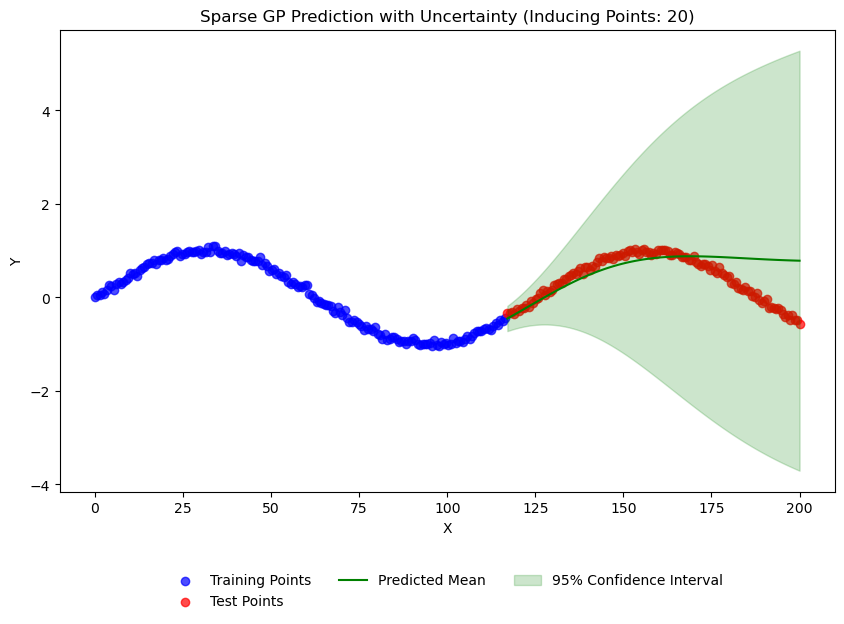

In [10]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive, False)

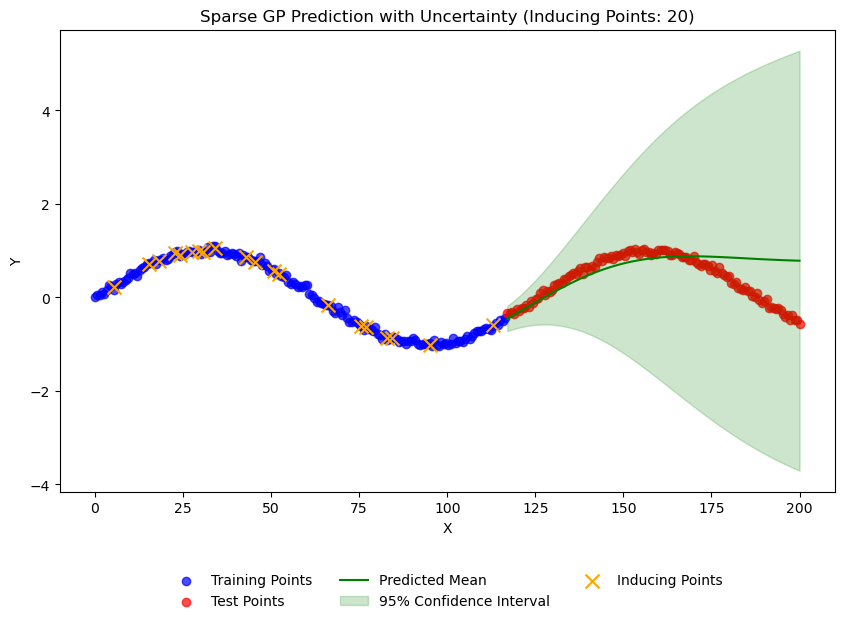

In [11]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

In [12]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[3]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[4]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[15]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train.shape[1]
i = 16
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

print(optimized_hyperparams)

Kernel Weights:
Kernel 1 (Squared-Exponential): 21.9173
Kernel 2 (Linear): 0.1767
Kernel 3 (Matérn): 0.1862
Kernel 4 (Sinusoidal): 0.0009
Kernel 5 (Spectral Mixture): 0.0725

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 98.05%
Kernel 2 (Linear): 0.79%
Kernel 3 (Matérn): 0.83%
Kernel 4 (Sinusoidal): 0.00%
Kernel 5 (Spectral Mixture): 0.32%

Other Hyperparameters:
Kernel 1 - Noise Variance: 0.0009
Kernel 1 - Signal Variance: 0.0725
Kernel 1 - Length Scale: 2610.4219
Kernel 2 - Noise Variance: 0.0009
Kernel 2 - Signal Variance: 1.4551
Kernel 3 - Noise Variance: 0.0009
Kernel 3 - Signal Variance: 1.5340
Kernel 3 - Length Scale: 22024.9961
Kernel 4 - Noise Variance: 0.0009
Kernel 4 - Signal Variance: 2.3543
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7183
Kernel 5 - Noise Variance: 0.0009

Spectral Mixture Kernel - Mixture 1:
Weight: 0.0376
Means: [1.20881]
Variances: [43.247284]

Spectral Mixture Kernel - Mixture 2:
Weight: 0.0291
Means: [2.8812811]
Variances

## NLPD on Test Data

In [13]:
train_nlpd = calculate_nlpd(X_train, Y_train, Z, optimized_hyperparams, sparse_gp_posterior_predictive)
test_nlpd = calculate_nlpd(X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: -1.1322
Test NLPD: 1.4255


## ELBO Maximization

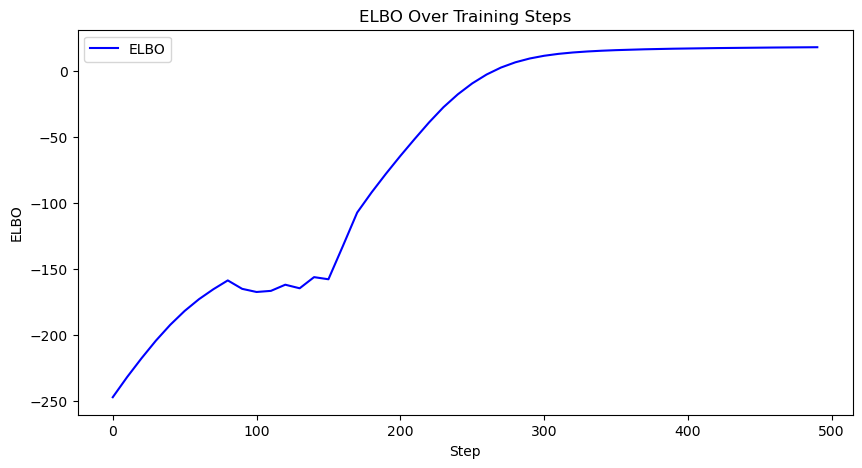

In [14]:
plot_elbo(history)

## Kernel Hyperparameters

In [15]:
# plot_kernel_hyperparameters(history)

# Test Experiment 2
Test on 100 inducing points.

## Parameter Initialization

In [16]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train, num_inducing=100)

# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train)

## Define the Optimization Loop for ELBO

In [17]:
# Set the gradient ascent step size and number of steps
step_size = 5e-3
num_steps = 500

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train, Y_train, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -266.35554595400174
Step 10, ELBO: -244.70460154421136
Step 20, ELBO: -227.83474947090772
Step 30, ELBO: -213.1789616261874
Step 40, ELBO: -199.91992305908713
Step 50, ELBO: -187.9926380882457
Step 60, ELBO: -177.355699467051
Step 70, ELBO: -167.75315555661334
Step 80, ELBO: -158.54603086884146
Step 90, ELBO: -165.64169696645774
Step 100, ELBO: -168.82019152167405
Step 110, ELBO: -166.71075328194232
Step 120, ELBO: -165.30758142894678
Step 130, ELBO: -164.117476457393
Step 140, ELBO: -162.6549706900471
Step 150, ELBO: -159.27298107843922
Step 160, ELBO: -136.64213825612939
Step 170, ELBO: -112.40359093284103
Step 180, ELBO: -97.37098572289744
Step 190, ELBO: -83.1988349110386
Step 200, ELBO: -69.62668202212151
Step 210, ELBO: -56.67370552836485
Step 220, ELBO: -44.432605540299136
Step 230, ELBO: -33.03653435377966
Step 240, ELBO: -22.634182643212114
Step 250, ELBO: -13.359570299452429
Step 260, ELBO: -5.346144802095068
Step 270, ELBO: 1.2213740357546783
Step 280, ELBO: 6.

## Predict and Plot the Results

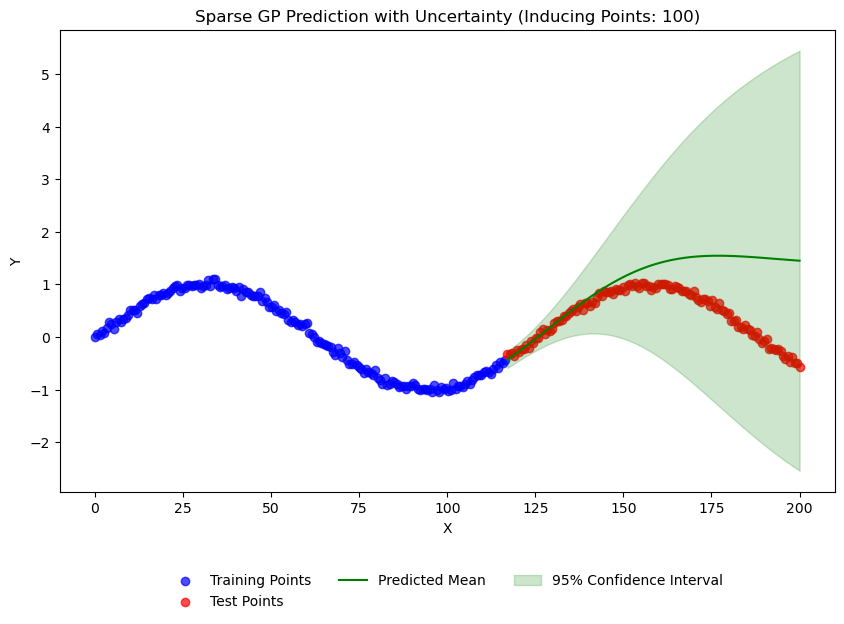

In [18]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive, False)

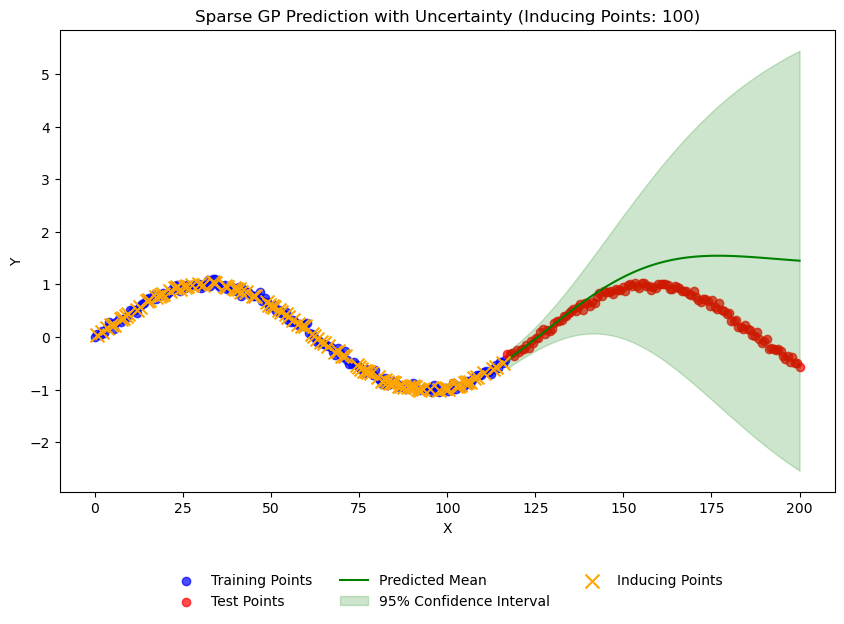

In [19]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

In [20]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[3]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[4]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[15]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train.shape[1]
i = 16
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

print(optimized_hyperparams)

Kernel Weights:
Kernel 1 (Squared-Exponential): 36.7612
Kernel 2 (Linear): 0.1767
Kernel 3 (Matérn): 0.2590
Kernel 4 (Sinusoidal): 0.0007
Kernel 5 (Spectral Mixture): 0.0436

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 98.71%
Kernel 2 (Linear): 0.47%
Kernel 3 (Matérn): 0.70%
Kernel 4 (Sinusoidal): 0.00%
Kernel 5 (Spectral Mixture): 0.12%

Other Hyperparameters:
Kernel 1 - Noise Variance: 0.0007
Kernel 1 - Signal Variance: 0.0436
Kernel 1 - Length Scale: 2971.7402
Kernel 2 - Noise Variance: 0.0007
Kernel 2 - Signal Variance: 1.4553
Kernel 3 - Noise Variance: 0.0007
Kernel 3 - Signal Variance: 2.1338
Kernel 3 - Length Scale: 22023.9023
Kernel 4 - Noise Variance: 0.0007
Kernel 4 - Signal Variance: 2.6783
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7183
Kernel 5 - Noise Variance: 0.0007

Spectral Mixture Kernel - Mixture 1:
Weight: 0.0197
Means: [1.3097167]
Variances: [57.441086]

Spectral Mixture Kernel - Mixture 2:
Weight: 0.0199
Means: [2.8812811]
Varianc

## NLPD

In [21]:
train_nlpd = calculate_nlpd(X_train, Y_train, Z, optimized_hyperparams, sparse_gp_posterior_predictive)
test_nlpd = calculate_nlpd(X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: -1.4253
Test NLPD: 6.0436


## ELBO Maximization


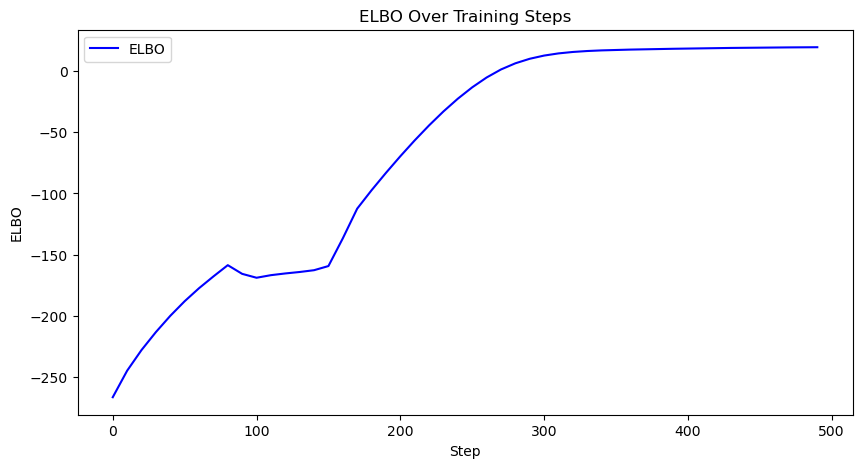

In [22]:
plot_elbo(history)

## Kernel Hyperparameters

In [23]:
# plot_kernel_hyperparameters(history)